In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import os
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import pandas as pd
from pytorch_transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from bs4 import BeautifulSoup as bs
import requests
import datetime
import FinanceDataReader as fdr
from requests.adapters import HTTPAdapter
import re
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error

2021-12-08 09:02:19.848619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 09:02:19.848639: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
companyName = '셀트리온' #예측하고 싶은 기업
predictDate = datetime.date(2021 , 12, 9) #예측하고 싶은 날짜

In [3]:
device = torch.device("cuda")

tokenizer_price = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bertmodel_price = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=4)

In [4]:
#BERT 모델을 위한 데이터 수집 과정

dataset_train_price = []
dataset_test_price = []

root = "new_exp_2020/"
list = os.listdir(root)
for cat in list:
    files = os.listdir(root + cat)
    for i,f in enumerate(files):
        if (f == '.ipynb_checkpoints'):
            continue
        fname = root + cat + "/" + f
        file = open(fname, "r", encoding="utf-8")
        strings = file.read()
        if i<480:
            dataset_train_price.append([strings, cat])
        elif i<604:
            dataset_test_price.append([strings,cat])
        file.close()
        
root2 = "new_exp_2019/"
list = os.listdir(root2)
for cat in list:
    files = os.listdir(root2 + cat)
    for i,f in enumerate(files):
        if (f == '.ipynb_checkpoints'):
            continue
        fname = root2 + cat + "/" + f
        file = open(fname, "r", encoding="utf-8")
        strings = file.read()
        if i<201:
            dataset_train_price.append([strings, cat])
        elif i<278:
            dataset_test_price.append([strings,cat])
        file.close()
        
root3 = "new_exp_2018/"
list = os.listdir(root3)
for cat in list:
    files = os.listdir(root3 + cat)
    for i,f in enumerate(files):
        if (f == '.ipynb_checkpoints'):
            continue
        fname = root3 + cat + "/" + f
        file = open(fname, "r", encoding="utf-8")
        strings = file.read()
        if i<281:
            dataset_train_price.append([strings, cat])
        elif i<356:
            dataset_test_price.append([strings,cat])
        file.close()

print(len(dataset_train_price), len(dataset_test_price))

3848 1069


In [5]:
print(dataset_train_price[0][0][:64]) #sentence
print(dataset_train_price[0][1]) #label

삼성전자, 미국 이동통신 사업자 'US 셀룰러'와 5G·4G 통신장비 공급 계약 체결 [르포] '시스템 반도체 1위
0


In [6]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx):
        # 현재 i[sent_idx] 가 본문
        self.sentences = [i[sent_idx][:64] for i in dataset]
        self.labels = [i[label_idx] for i in dataset]

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i]

    def __len__(self):
        return (len(self.labels))

In [7]:
batch_size = 4
num_epochs = 15
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [8]:
data_train_price = BERTDataset(dataset_train_price, 0, 1)
data_test_price = BERTDataset(dataset_test_price, 0, 1)

In [9]:
train_dataloader_price = torch.utils.data.DataLoader(data_train_price, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader_price = torch.utils.data.DataLoader(data_test_price, batch_size=batch_size, num_workers=5, shuffle=True)

In [10]:
bertmodel_price.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [11]:
for text,label in train_dataloader_price:
    print(text)
    result = tuple((int(x[0])) for x in label)
    result = torch.tensor(result)
    print(result)
    break

('[종합] LG화학, SK이노베이션 국내 소송전서 1승…"6년 전 합의 파기 아냐" SK이노베이션-LG화학, 배터리 ', "카카오게임즈 '블레이드2', 명예의 전당 랭킹 시스템 추가", "삼성전자, '비스포크' 김치냉장고 신제품 출시 삼성전자, 유럽 '청정가전' 시장 본격 공략…IFA 2019 전시 삼", "삼성전자, '갤럭시 북 플렉스', '갤럭시 북 이온' 사전판매 실시 삼성전자, 中시안 낸드 2공장 80억달러 추가 ")
tensor([0, 0, 1, 3])


In [12]:
optimizer = optim.AdamW(bertmodel_price.parameters(), lr=1e-6)
itr=1
p_itr=200
total_loss = 0
total_len = 0
total_correct = 0

for epoch in range(num_epochs):
    
    bertmodel_price.train()
    total_loss = 0
    total_len = 0
    total_correct = 0
    for sentence, label in train_dataloader_price:
        optimizer.zero_grad()
        
        encoded_list = [tokenizer_price.encode(t,add_special_tokens=True) for t in sentence]
        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
        
        sample = torch.tensor(padded_list)
        label = tuple((int(x[0])) for x in label)
        label = torch.tensor(label)
        sample = sample.to(device)
        label = label.to(device)
        
        labels = torch.tensor(label)
        outputs = bertmodel_price(sample, labels=labels)
        loss, logits = outputs

        pred = torch.argmax(F.softmax(logits), dim=1)        
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
        total_loss += loss.item()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        #scheduler.step()    
    print('[Epoch {}/{}] -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, num_epochs, total_loss, total_correct/total_len))
    
    bertmodel_price.eval()
    t_total_correct = 0
    t_total_len = 0
    for sentence, label in test_dataloader_price:
        encoded_list = [tokenizer_price.encode(t,add_special_tokens=True) for t in sentence]
        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
        
        sample = torch.tensor(padded_list)
        label = tuple((int(x[0])) for x in label)
        label = torch.tensor(label)
        sample = sample.to(device)
        label = label.to(device)
        
        labels = torch.tensor(label)
        outputs = bertmodel_price(sample, labels=labels)
        _, logits = outputs
        
        pred = torch.argmax(F.softmax(logits), dim=1)        
        correct = pred.eq(labels)
        t_total_correct += correct.sum().item()
        t_total_len += len(labels)
    print('[Epoch {}/{}] -> Test Accuracy: {:.3f}'.format(epoch+1, num_epochs, t_total_correct/t_total_len))

/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 1/15] -> Train Loss: 1334.2045, Accuracy: 0.256


/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 1/15] -> Test Accuracy: 0.292
[Epoch 2/15] -> Train Loss: 1270.6316, Accuracy: 0.333
[Epoch 2/15] -> Test Accuracy: 0.319
[Epoch 3/15] -> Train Loss: 1186.0062, Accuracy: 0.381
[Epoch 3/15] -> Test Accuracy: 0.301
[Epoch 4/15] -> Train Loss: 1164.4908, Accuracy: 0.407
[Epoch 4/15] -> Test Accuracy: 0.349
[Epoch 5/15] -> Train Loss: 1156.6984, Accuracy: 0.406
[Epoch 5/15] -> Test Accuracy: 0.304
[Epoch 6/15] -> Train Loss: 1151.5101, Accuracy: 0.397
[Epoch 6/15] -> Test Accuracy: 0.308
[Epoch 7/15] -> Train Loss: 1138.6320, Accuracy: 0.408
[Epoch 7/15] -> Test Accuracy: 0.309
[Epoch 8/15] -> Train Loss: 1136.3347, Accuracy: 0.395
[Epoch 8/15] -> Test Accuracy: 0.310
[Epoch 9/15] -> Train Loss: 1120.8658, Accuracy: 0.412
[Epoch 9/15] -> Test Accuracy: 0.367
[Epoch 10/15] -> Train Loss: 1098.7267, Accuracy: 0.423
[Epoch 10/15] -> Test Accuracy: 0.348
[Epoch 11/15] -> Train Loss: 1086.2116, Accuracy: 0.426
[Epoch 11/15] -> Test Accuracy: 0.392
[Epoch 12/15] -> Train Loss: 1078.4565,

In [13]:
bertmodel_price.eval()

total_loss = 0
total_len = 0
total_correct = 0

for sentence, label in test_dataloader_price:
    encoded_list = [tokenizer_price.encode(t,add_special_tokens=True) for t in sentence]
    padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
    sample = torch.tensor(padded_list)
    label = tuple((int(x[0])) for x in label)
    label = torch.tensor(label)
    sample = sample.to(device)
    label = label.to(device)
        
    labels = torch.tensor(label)
    outputs = bertmodel_price(sample, labels=labels)
    _, logits = outputs

    pred = torch.argmax(F.softmax(logits), dim=1)
    correct = pred.eq(labels)
    total_correct += correct.sum().item()
    total_len += len(labels)

print('Test accuracy: ', total_correct / total_len)

/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy:  0.33863423760523853


In [14]:
device = torch.device("cuda")
bertmodel_crawl, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [15]:
dataset_train_crawl = []
dataset_test_crawl = []

root = "newsData/"
list = os.listdir(root)
for cat in list:
    files = os.listdir(root + cat)
    for i,f in enumerate(files):
        fname = root + cat + "/" + f
        file = open(fname, "r", encoding="utf-8")
        strings = file.read()
        if i<170:
            dataset_train_crawl.append([strings, cat])
        else:
            dataset_test_crawl.append([strings,cat])
        file.close()

print(len(dataset_train_crawl), len(dataset_test_crawl))

1360 240


In [16]:
tokenizer_crawl = get_tokenizer()
tok_crawl = nlp.data.BERTSPTokenizer(tokenizer_crawl, vocab, lower=False)

using cached model


In [17]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [18]:
max_len = 64
batch_size = 16
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [19]:
data_train_crawl = BERTDataset(dataset_train_crawl, 0, 1, tok_crawl, max_len, True, False)
data_test_crawl = BERTDataset(dataset_test_crawl, 0, 1, tok_crawl, max_len, True, False)

In [20]:
train_dataloader_crawl = torch.utils.data.DataLoader(data_train_crawl, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader_crawl = torch.utils.data.DataLoader(data_test_crawl, batch_size=batch_size, num_workers=5, shuffle=True)

In [22]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=8,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [23]:
my_bertmodel_crawl = BERTClassifier(bertmodel_crawl,  dr_rate=0.5).to(device)

In [24]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in my_bertmodel_crawl.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in my_bertmodel_crawl.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [25]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [26]:
t_total = len(train_dataloader_crawl) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [27]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [28]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [29]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [30]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    my_bertmodel_crawl.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader_crawl)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = my_bertmodel_crawl(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(my_bertmodel_crawl.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        # if batch_id % log_interval == 0:
        #     print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    my_bertmodel_crawl.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader_crawl)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = my_bertmodel_crawl(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 1 train acc 0.2852941176470588


/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1 test acc 0.7541666666666667


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 2 train acc 0.8102941176470588


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2 test acc 0.8583333333333333


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 3 train acc 0.8985294117647059


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3 test acc 0.8208333333333333


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 4 train acc 0.9345588235294118


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4 test acc 0.7916666666666666


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 5 train acc 0.9632352941176471


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5 test acc 0.8708333333333333


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 6 train acc 0.9794117647058823


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 6 test acc 0.8708333333333333


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 7 train acc 0.9911764705882353


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 7 test acc 0.8916666666666667


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 8 train acc 0.9933823529411765


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 8 test acc 0.8875


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 9 train acc 0.9963235294117647


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 9 test acc 0.8958333333333334


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 10 train acc 0.9963235294117647


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 10 test acc 0.8958333333333334


In [31]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

In [32]:
def loadStockData(symbol, startDate, endDate):
    df_stock = fdr.DataReader(symbol, startDate.isoformat(), endDate.isoformat())
    df_stock = df_stock[['Close']]
    df_stock['Fluctuation'] = df_stock['Close'].div(df_stock['Close'].shift(1)).apply(lambda x : (x - 1) * 100)
    return df_stock

In [33]:
def get_ticker(company_name):
    return str(df_kospi.loc[df_kospi['Name'] == company_name]['Symbol'].values[0])

In [34]:
def aggregateTitles(companyName, url):
    resp = requests.get(url)
    titles = []
    cate = ["정치","경제","사회", "생활/문화","세계","기술/IT", "연예", "스포츠"]

    for item in bs(resp.text, 'xml').find_all('item'):
        title = item.title.string
        source = item.source.string # 언론사
        if(companyName in title):
            newtitle = str(title.encode('utf-8'))
            newtitle = re.sub(companyName,"",title)
            tmp = [newtitle]
            transform = nlp.data.BERTSentenceTransform(tok_crawl, max_len, pad=True, pair=False)
            tokenized = transform(tmp)
            
            my_bertmodel_crawl.eval()
            result = my_bertmodel_crawl(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
            idx = result.argmax().cpu().item()
            if(idx==1 or idx==5):
                titles.append(title[:title.find(source) - 3])

    return ' '.join(titles)

In [35]:
df_kospi = fdr.StockListing('KOSPI')
mycompanyNum = get_ticker(companyName)
df_stock = loadStockData(mycompanyNum, predictDate - datetime.timedelta(days=10), predictDate-datetime.timedelta(days=1))
dateList = df_stock.index.map(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d')).values
country = ('ko', 'KR')

In [36]:
idx = 1
while idx < len(dateList):
    url = f'https://news.google.com/rss/search?q={companyName}+after:{dateList[idx - 1]}+before:{dateList[idx]}& \
            hl={country[0]}&gl={country[1]}&ceid={country[1]}:{country[0]}'
    aggTitle = aggregateTitles(companyName, url)
    idx += 1

/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [37]:
aggTitle

'셀트리온 40만, SK바이오 33만 ... 제약·바이오株 움직이는 개미들 셀트리온, 지배구조 개편·파이프라인 추가…제2의 도약 밑그림 셀트리온 ‘렉키로나’ 한국·유럽 이어 호주서도 허가…주가 반등은 언제쯤? 셀트리온, 류머티즘 관절염약 \'악템라\' 바이오시밀러 개발 착수 에코프로비엠 시총 11.7조…1위 셀트리온헬스케어 바짝 추격 셀트리온, 3.19% 오르며 체결강도 강세 지속(199%) [7일 제약바이오 소식] 유한양행·LG화학·일동제약·셀트리온 셀트리온 코로나19 치료제 \'렉키로나\' 호주 조건부 허가 셀트리온제약, 3.00% 오르며 체결강도 강세 지속(181%) [공매도 TOP 10 종목] 코스닥, 현대바이오 공매도 1위, 셀트리온헬스케어-텔콘RF제약-씨아이에스 등 순위 올라 [한국증시 인기주식] 삼성전자 CEO프리미엄 입나, 셀트리온 내년 영업익 1조 전망, 카카오 내년 실적 전망치 상향 SK하이닉스·현대중·셀트리온...연말 대기업 채용문 ‘활짝’ [금일 의료·제약 주요기사]한미약품 "폐암 신약 포지오티닙 미국 FDA 시판허가 신청"...셀트리온, \'렉키로나\' 호주 조건부허가 획득 外 코스닥, 기관과 개인 매수에 상승 마감…천보, 에이치엘비, 알테오젠 상승 VS 위메이드, 펄어비스, 셀트리온헬스케어 하락'

In [40]:
def testModel(model, seq):
    cate = ["대폭 하락","소폭 하락","소폭 상승", "대폭 상승"]
    tmp = [seq]
    encoded_list = [tokenizer_price.encode(t,add_special_tokens=True) for t in tmp]
    padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
    sample = torch.tensor(padded_list)

    labels = torch.tensor([1]).unsqueeze(0)
    sample = sample.to(device)
    labels = labels.to(device)
    outputs = model(sample, labels=labels)
    _, logits = outputs

    pred = torch.argmax(F.softmax(logits), dim=1)

    print("기사로 본 주가는:", cate[pred], ", 신뢰도 {:.2f}%".format(softmax(logits,pred)))

In [41]:
testModel(bertmodel_price, aggTitle)

기사로 본 주가는: 대폭 상승 , 신뢰도 27.20%


/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [42]:
mycompany = fdr.DataReader(mycompanyNum)
mycompany

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2005-07-19,5598,6433,5438,6439,499088,NaN
2005-07-20,6424,6424,5470,5475,422688,-0.149713
2005-07-21,5391,5499,4785,4798,182685,-0.123653
2005-07-22,4884,4884,4617,4664,69921,-0.027928
2005-07-25,4587,4967,4587,4723,61036,0.012650
...,...,...,...,...,...,...
2021-12-02,210000,214000,206500,213000,522300,0.007092
2021-12-03,211000,212500,206500,210500,633417,-0.011737
2021-12-06,208000,210500,205000,206500,560276,-0.019002


In [43]:
price = mycompany[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price

/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Close
Date,
2005-07-19,-0.976959
2005-07-20,-0.981848
2005-07-21,-0.985282
2005-07-22,-0.985961
2005-07-25,-0.985662
...,...
2021-12-02,0.070659
2021-12-03,0.057980
2021-12-06,0.037693


In [44]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3228, 19, 1)
y_train.shape =  (3228, 1)
x_test.shape =  (807, 19, 1)
y_test.shape =  (807, 1)


In [45]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [46]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [47]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [48]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [49]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5367945432662964
Epoch  1 MSE:  0.3447377681732178
Epoch  2 MSE:  0.17068733274936676
Epoch  3 MSE:  0.08807312697172165
Epoch  4 MSE:  0.1460975855588913
Epoch  5 MSE:  0.0775093361735344
Epoch  6 MSE:  0.08181560039520264
Epoch  7 MSE:  0.09765838086605072
Epoch  8 MSE:  0.09971487522125244
Epoch  9 MSE:  0.08960913866758347
Epoch  10 MSE:  0.07493787258863449
Epoch  11 MSE:  0.06433280557394028
Epoch  12 MSE:  0.06379064172506332
Epoch  13 MSE:  0.06988836079835892
Epoch  14 MSE:  0.07024939358234406
Epoch  15 MSE:  0.06067483127117157
Epoch  16 MSE:  0.04937398433685303
Epoch  17 MSE:  0.04291161894798279
Epoch  18 MSE:  0.040364619344472885
Epoch  19 MSE:  0.03682396188378334
Epoch  20 MSE:  0.02808198891580105
Epoch  21 MSE:  0.014881791546940804
Epoch  22 MSE:  0.005814187694340944
Epoch  23 MSE:  0.0080427136272192
Epoch  24 MSE:  0.010550533421337605
Epoch  25 MSE:  0.02085641212761402
Epoch  26 MSE:  0.009735011495649815
Epoch  27 MSE:  0.006548397708684206
E

In [50]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

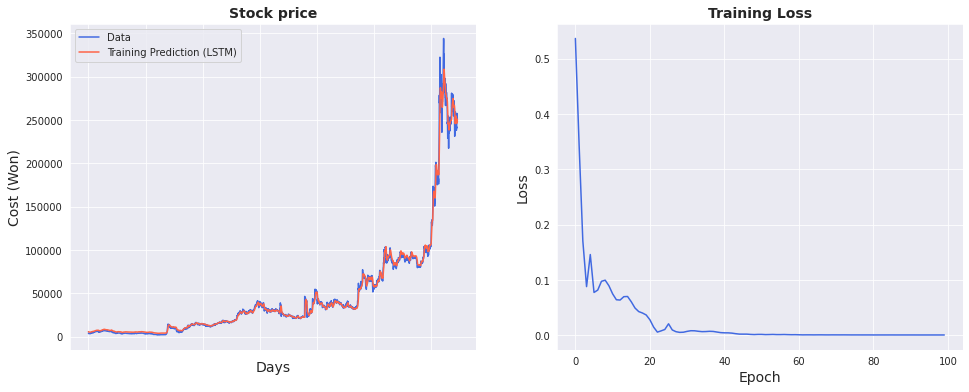

In [51]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (Won)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [52]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 4964.96 RMSE
Test Score: 13215.76 RMSE


Text(0, 0.5, 'Cost (Won)')

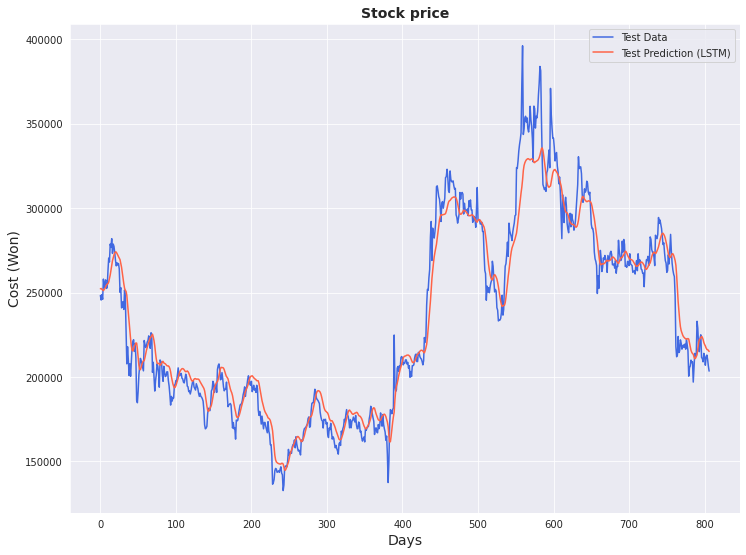

In [53]:
sns.set_style("darkgrid")    

plt.figure(figsize=(12, 9))
predict_test = pd.DataFrame(y_test_pred)
original_test = pd.DataFrame(y_test)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Test Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (Won)", size = 14)

In [54]:
def classifyFluctuation(fluctuation):
    if fluctuation < -2.5:
        return 0
    elif fluctuation < 0:
        return 1
    elif fluctuation < 2.5:
        return 2
    else:
        return 3

In [55]:
#companyName = 'LG전자'
#mycompanyNum = get_ticker(companyName)
#predictDate = datetime.date(2021 , 12, 7)

forpredict = fdr.DataReader(mycompanyNum, predictDate - datetime.timedelta(days=40), predictDate- datetime.timedelta(days=1))
forpredict = forpredict[-19:]
price_apply = forpredict[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price_apply['Close'] = scaler.fit_transform(price_apply['Close'].values.reshape(-1,1))

data_raw = price_apply.to_numpy()
myset = torch.from_numpy(data_raw).type(torch.Tensor)
myset = myset.unsqueeze(dim=0)
myresult = model(myset)
myresult_price = scaler.inverse_transform(myresult.detach().numpy())

mytoday = myresult_price[0][0]
myyesterday = fdr.DataReader(mycompanyNum,predictDate-datetime.timedelta(days=1))['Close'][0]
myfluc = (mytoday-myyesterday)/(myyesterday)*100

cate = ["대폭 하락","소폭 하락","소폭 상승", "대폭 상승"]
print("차트로 본 주가는:", cate[classifyFluctuation(myfluc)],", 예측가 {:.2f}원".format(mytoday))
testModel(bertmodel_price, aggTitle)

차트로 본 주가는: 소폭 상승 , 예측가 208706.17원
기사로 본 주가는: 대폭 상승 , 신뢰도 27.20%


/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/minhyuk/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
